# Your Community Eatery

## Searching for insight into profiling users based on the text of their reviews


In [1]:
# Project specific modules
from src.pipeline import YourCommunityEatery
from website.src.functions import build_item_map, get_recs

# Avoid restarting Kernal each time we update modules
%load_ext autoreload
%autoreload 2

# The basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dictionaries for cleaning
from PyDictionary import PyDictionary
import urbandict

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Surprise modeling
from surprise import SVD
import surprise
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split

# Persistance
import pickle

# Housekeeping
from io import StringIO
from datetime import datetime
import time
import requests
import os

# Initial EDA

This dataset is actually too big to simply load into a Pandas dataframe (at least on my machine - 8 GB memory). Although I know people with 16 GB machines have loaded it successfully, so far I get memory errors when trying to load it onto a 16 GB AWS EC2 instance (and I'm still searching for an answer/solution on that). Regardless, we can do some initial EDA to just see what we have by using Spark!

In [2]:
# Read data in from files 
# There is quite a bit of data to load and it has to be filtered 
# based on some conditions to fit in memory, so this takes a while
# Expect over 80 total chunks to be read in...
pipe = YourCommunityEatery()
# pipe.read_data(data_dir_path='data/')

In [3]:
# Alternatively, once you've done this once, you can persist
# the results from above so that you can just load it from a file
# next time :) 
# This isn't super fast, but much better than the above.
# pipe.persist_subject_data()
pipe.bus_review_df = pd.read_json('data/bus_review_df.json', orient = 'records')

# EDA
#### At this point our data is saved in 'bus_review_df' which is an attribute of our pipe object

What time frame do these reviews span?

In [4]:
begin = pipe.bus_review_df.date.min()
end = pipe.bus_review_df.date.max()
print('These ratings range from {} to {}.'.format(begin.year, end.year))

These ratings range from 2005 to 2019.


Long span of data, nice! And what kind of distribution of reviews over time might we see for that duration?

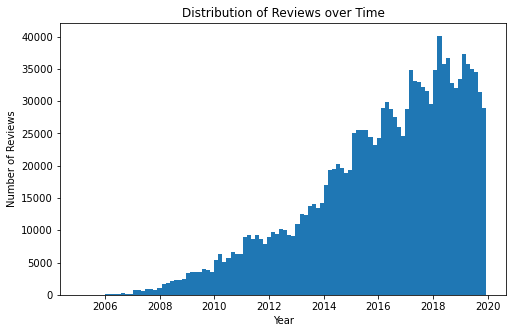

In [5]:
ax = pipe.bus_review_df.date.hist(bins = 100, figsize = (8, 5))
ax.grid(False)
ax.set_title('Distribution of Reviews over Time')
ax.set_xlabel('Year')
_ = ax.set_ylabel('Number of Reviews')

Look at that growth! Good for you, Yelp. Interesting trends after 2015, seasonality for reviews? Interesting...but out of our scope.

What is the distribution of number of users to have reviewed each restaurant? 


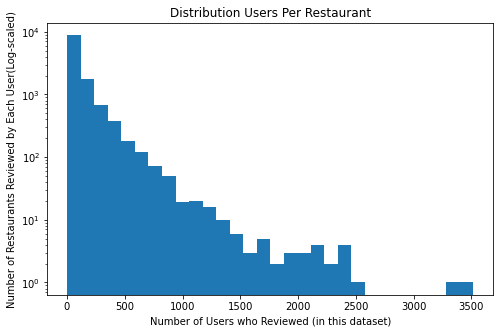

In [6]:
groups = pipe.bus_review_df.groupby('business_id')
ax = groups.user_id.nunique().hist(bins = 30, figsize = (8, 5))
ax.grid(False)
ax.set_yscale('log')
ax.set_xlabel('Number of Users who Reviewed (in this dataset)')
ax.set_title('Distribution Users Per Restaurant')
_ = ax.set_ylabel('Number of Restaurants Reviewed by Each User(Log-scaled)')

Keeping in mind this is log-scaled on the y axis, this data appears to be exponentially distributed.


What is the distribution of reviews per user?


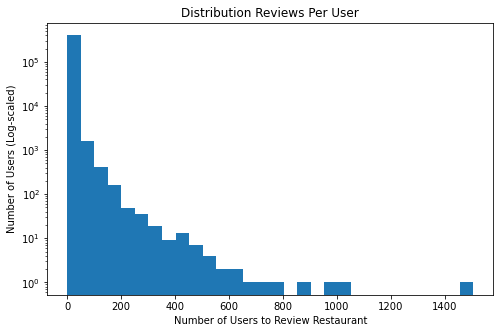

In [7]:
groups = pipe.bus_review_df.groupby('user_id')
ax = groups.review_id.nunique().hist(bins = 30, figsize = (8, 5))
ax.grid(False)
ax.set_yscale('log')
ax.set_xlabel('Number of Users to Review Restaurant')
ax.set_title('Distribution Reviews Per User')
_ = ax.set_ylabel('Number of Users (Log-scaled)')

From the graph above, we are able to see that this is exponentially distributed. There are several users who have made significant numbers of reviews. Normally this might be cause for concern that their reviews are not legitimate; however, this dataset consists only of reviews that Yelp has validated and "recommended", so they are likely just very passionate about food. But skeptical scientists that we are, we'll not just take their word for it...ok, I admit that I'm mostly just curious to see what kind of stuff a person who writes over 1,200 reviews has to say.

Let's verify the text of the highest volume user to be sure they are not a bot. As shown below, only one user exceeded 1000 reviews and their id is 'ELcQDlf69kb-ihJfxZyL0A'. Feel free to adjust the index on the .iloc to see a few different reivews (just put in a number between 0 and 1277).

In [8]:
pipe.bus_review_df[pipe.bus_review_df.user_id == 'ELcQDlf69kb-ihJfxZyL0A'].text.iloc[356]

"Since I'm an ex-New Yorker, it was strange that I had not been to this pizza chain yet in my time in Arizona. Looking at the menu online, it just didn't seem like I should be spending north of $22 for a large pie with no topping. The lunch special was a better way to sample the slices and I had a couple of slices and a drink for $6.99. The slices in the case already had toppings, but if you order the special, you can get additional toppings at no charge on both slices and welcome mushrooms and peppers to the pepperoni party. The slices were good size, very foldable and it was a good lunch. The sauce might have had a touch too much garlic, but otherwise it now might be worth buying a pie, although the prices is high (should be $15 large with one topping). At this location, the staff and manager were both nice, checking on my food quality and telling me the history of NYPD. Will return."

Clearly, this is not a bot...just definitely someone who has a lot of time on their hands. Outlier though they may be, their reviews appear to be genuine, so we will graciously accept their contributions to our density.

# Filter based on year

#### Let's only take more recent reviews to keep our dataset more manageable and also account for changes over time at least a bit

In [9]:
pipe.filter_by_review_date(threshold = 2013)


# Start cleaning & prep for NLP

In [10]:
# Check memory
pipe.bus_review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1234678 entries, 0 to 1442737
Data columns (total 18 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   review_id     1234678 non-null  object        
 1   user_id       1234678 non-null  object        
 2   business_id   1234678 non-null  object        
 3   review_stars  1234678 non-null  int64         
 4   useful        1234678 non-null  int64         
 5   funny         1234678 non-null  int64         
 6   cool          1234678 non-null  int64         
 7   text          1234678 non-null  object        
 8   date          1234678 non-null  datetime64[ns]
 9   name          1234678 non-null  object        
 10  address       1234678 non-null  object        
 11  city          1234678 non-null  object        
 12  state         1234678 non-null  object        
 13  latitude      1234678 non-null  float64       
 14  longitude     1234678 non-null  float64       
 15

In [11]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(pipe.bus_review_df.text)

In [12]:
all_words = vectorizer.get_feature_names()
text_df = pd.DataFrame({'words':all_words})
text_df.sample(5)

,words
74367,hammich
174208,wole
122459,pocketdogg
9298,affording
137247,saltenas


# Determine words in regular dictionary

Note that PyDictionary is really annoying in that it doesn't raise an error for words that it doesn't have a definition for, nor does it let you suppress the warning. So I modified the source code for it in my site-packages. They had a print statement in their `except` statement. I chnaged it to a `raise` so that I could use `try/except` here.

In [84]:
def get_latest_dictionary():
    latest = 0
    for item in os.listdir('./data/dictionaries/'):
        if 'in_dict' in item:
            record = item.split('_')[-1].split('.')[0]
            if int(record) > latest:
                latest = int(record)
                pick = item
    return pd.read_csv('./data/dictionaries/'+pick)
    

def get_dictionary(df, source='standard', record_frequency = 100, hard_stop=1000):
    if source == 'standard':
        dictionary = PyDictionary()
    import urbandict        
    in_dict = []

    for idx, word in df.iterrows():
        try:
            if source == 'standard':
                dictionary.meaning(word[0])
                in_dict.append(1)
            elif source == 'urban':
                dictionary.define(word[0])
                in_dict.append(1)
        except:
            in_dict.append(0)

        if (idx+1) % record_frequency == 0:
            print(f'Completed {idx} out of {len(df)} records. Saving results to file...')
            now = int(time.time())
            in_dict_df = pd.DataFrame({'word':df.words.iloc[:idx+1], 'in_dict':in_dict})
            in_dict_df.to_csv(f'./data/dictionaries/in_dict_{source}{now}.csv')
            
            if hard_stop is not None and (idx+1) >= hard_stop:
                print(f'Hitting hard stop limit of {hard_stop}. Done for now.')
                return in_dict_df
                
    now = int(time.time())
    in_dict_df = pd.DataFrame({'word':df.words.iloc[:idx+1], 'in_dict':in_dict})
    in_dict_df.to_csv(f'./data/dictionaries/in_dict_{source}{now}.csv')
    return in_dict_df
            
def resume_dictionary(df, report_frequency=500, record_frequency=500, hard_stop=10000):
    dictionary = PyDictionary()
    in_dict = []

    # Find where we left off
    in_dict_df = get_latest_dictionary()
    in_dict = in_dict_df.in_dict.to_list()
    start = in_dict_df.iloc[-1,:].name + 1
    print(f'Starting from record number {start}')
    # Pick up from there
    for idx, word in df.iloc[start:, :].iterrows():

        try:
            dictionary.meaning(word[0])
            in_dict.append(1)
        except:
            in_dict.append(0)

        if ((idx+1-start) % hard_stop) == 0 and idx:
            print(f'Completed {idx+1} out of {len(df)} records, and met hard stop.\nSaving results to file then quitting...')
            now = int(time.time())
            in_dict_df = pd.DataFrame({'word':df.words.iloc[:idx+1], 'in_dict':in_dict})
            in_dict_df.to_csv(f'./data/dictionaries/in_dict_{now}.csv')
            return in_dict_df
            
        if (idx+1) % record_frequency == 0:
            print(f'Completed {idx+1} out of {len(df)} records. Saving results to file...')
            now = int(time.time())
            in_dict_df = pd.DataFrame({'word':df.words.iloc[:idx+1], 'in_dict':in_dict})
            in_dict_df.to_csv(f'./data/dictionaries/in_dict_{now}.csv')
        elif (idx+1) % report_frequency == 0:
            print(f'Completed {idx+1} out of {len(df)} records.')

    now = int(time.time())    
    in_dict_df = pd.DataFrame({'word':df.words.iloc[:idx+1], 'in_dict':in_dict})
    in_dict_df.to_csv(f'./data/dictionaries/in_dict_{now}.csv')
    print('Dictionary run of dataset complete!')
    return in_dict_df
        

# Run above functions for dictionary production:

In [51]:
# this = resume_dictionary(text_df, report_frequency=500, record_frequency=1000, hard_stop=10000)

Starting from record number 180000


/Users/Tyler/anaconda3/envs/yelp/lib/python3.8/site-packages/PyDictionary/utils.py:5: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 5 of the file /Users/Tyler/anaconda3/envs/yelp/lib/python3.8/site-packages/PyDictionary/utils.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  return BeautifulSoup(requests.get(url).text)


Dictionary run of dataset complete!


In [64]:
this.in_dict.mean()

0.28232872227678546

In [88]:
urban = get_dictionary(text_df, source='urban', record_frequency=1000, hard_stop=10000)
urban

Completed 999 out of 180219 records. Saving results to file...
Completed 1999 out of 180219 records. Saving results to file...
Completed 2999 out of 180219 records. Saving results to file...
Completed 3999 out of 180219 records. Saving results to file...
Completed 4999 out of 180219 records. Saving results to file...
Completed 5999 out of 180219 records. Saving results to file...
Completed 6999 out of 180219 records. Saving results to file...
Completed 7999 out of 180219 records. Saving results to file...
Completed 8999 out of 180219 records. Saving results to file...
Completed 9999 out of 180219 records. Saving results to file...
Hitting hard stop limit of 10000. Done for now.


,word,in_dict
0,00,0
1,000,0
2,0000,0
3,00000,0
4,000000,0
...,...,...
9995,ahwatuckee,0
9996,ahwatukee,0
9997,ahwatukee411,0
9998,ahwatukeee,0


In [89]:
urban.in_dict.mean()

0.0

In [17]:
# lda = LatentDirichletAllocation(n_components=5, random_state = 0)
# lda.fit(X)
# lda.transform(X[-2:])